<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [17]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

##Load data

In [18]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [19]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [20]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [21]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800


In [22]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [23]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [24]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [25]:
df.head()

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408


In [26]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800


In [27]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [28]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [29]:
df.to_numpy()

array([[ 0.10865862,  1.73640748, -0.04643219,  0.89600774, -0.20447961,
        -1.69979736],
       [-0.4353983 ,  1.18142902,  2.13442897, -0.20237181,  1.18591631,
         0.21689601],
       [ 1.2121556 ,  0.51798477, -1.06110403,  0.32549229, -1.21682289,
        -0.44892695],
       [-1.47220961,  0.75857516, -0.5507875 , -0.58909974, -0.63734102,
         0.09121457],
       [ 0.18388676,  0.87587181, -0.19646106,  1.10608294, -0.7578407 ,
         0.57740814],
       [ 0.41943005, -0.19208007, -0.84355751,  0.94249141, -0.29734231,
         1.23110091],
       [ 0.50261414,  0.62200065,  0.21393241,  0.55730245,  0.14847546,
        -0.72552417],
       [-1.68867978, -0.54737005, -0.41329115,  0.57976491, -1.13183853,
        -0.36180002]])

In [30]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [31]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.146193,0.619102,-0.095409,0.451959,-0.363909,-0.139929
std,0.998650,0.724951,0.991477,0.588103,0.778411,0.886072
min,-1.688680,-0.547370,-1.061104,-0.589100,-1.216823,-1.699797
25%,-0.694601,0.340469,-0.623980,0.193526,-0.851340,-0.518076
50%,0.146273,0.690288,-0.304876,0.568534,-0.467342,-0.135293
75%,0.440226,0.952261,0.018659,0.907629,-0.116241,0.307024
max,1.212156,1.736407,2.134429,1.106083,1.185916,1.231101


In [32]:
df

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800


In [33]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,0.108659,-0.435398,1.212156,-1.472210,0.183887,0.419430,0.502614,-1.688680
B,1.736407,1.181429,0.517985,0.758575,0.875872,-0.192080,0.622001,-0.547370
C,-0.046432,2.134429,-1.061104,-0.550788,-0.196461,-0.843558,0.213932,-0.413291
D,0.896008,-0.202372,0.325492,-0.589100,1.106083,0.942491,0.557302,0.579765
E,-0.204480,1.185916,-1.216823,-0.637341,-0.757841,-0.297342,0.148475,-1.131839
F,-1.699797,0.216896,-0.448927,0.091215,0.577408,1.231101,-0.725524,-0.361800


In [34]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,-1.699797,-0.204480,0.896008,-0.046432,1.736407,0.108659
2023-01-02,0.216896,1.185916,-0.202372,2.134429,1.181429,-0.435398
2023-01-03,-0.448927,-1.216823,0.325492,-1.061104,0.517985,1.212156
2023-01-04,0.091215,-0.637341,-0.589100,-0.550788,0.758575,-1.472210
2023-01-05,0.577408,-0.757841,1.106083,-0.196461,0.875872,0.183887
2023-01-06,1.231101,-0.297342,0.942491,-0.843558,-0.192080,0.419430
2023-01-07,-0.725524,0.148475,0.557302,0.213932,0.622001,0.502614
2023-01-08,-0.361800,-1.131839,0.579765,-0.413291,-0.547370,-1.688680


In [35]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797


In [36]:
df

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800


##Getting

In [37]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    0.108659
2023-01-02   -0.435398
2023-01-03    1.212156
2023-01-04   -1.472210
2023-01-05    0.183887
2023-01-06    0.419430
2023-01-07    0.502614
2023-01-08   -1.688680
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [38]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927


In [39]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215


In [40]:
df

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800


##Selection by label

In [41]:
df.loc[dates[1]]

A   -0.435398
B    1.181429
C    2.134429
D   -0.202372
E    1.185916
F    0.216896
Name: 2023-01-02 00:00:00, dtype: float64

In [42]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,0.108659,0.896008
2023-01-02,-0.435398,-0.202372
2023-01-03,1.212156,0.325492
2023-01-04,-1.472210,-0.589100
2023-01-05,0.183887,1.106083
2023-01-06,0.419430,0.942491
2023-01-07,0.502614,0.557302
2023-01-08,-1.688680,0.579765


In [43]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-1.472210,-0.589100
2023-01-05,0.183887,1.106083
2023-01-06,0.419430,0.942491


In [44]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -1.47221
D   -0.58910
Name: 2023-01-04 00:00:00, dtype: float64

In [45]:
# For getting a scalar value
df.loc[dates[1], "D"]

-0.2023718065697082

In [46]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

-0.2023718065697082

##Selection by position

In [47]:
df.iloc[3]

A   -1.472210
B    0.758575
C   -0.550788
D   -0.589100
E   -0.637341
F    0.091215
Name: 2023-01-04 00:00:00, dtype: float64

In [48]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-1.472210,0.758575
2023-01-05,0.183887,0.875872


In [49]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-0.435398,2.134429
2023-01-03,1.212156,-1.061104
2023-01-05,0.183887,-0.196461


In [50]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927


In [51]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,1.736407,-0.046432
2023-01-02,1.181429,2.134429
2023-01-03,0.517985,-1.061104
2023-01-04,0.758575,-0.550788
2023-01-05,0.875872,-0.196461
2023-01-06,-0.192080,-0.843558
2023-01-07,0.622001,0.213932
2023-01-08,-0.547370,-0.413291


In [52]:
# For getting values explicitly
df.iloc[1, 1]

1.1814290166474786

In [53]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

1.1814290166474786

## Boolean indexing
Using a single column's values to select data:

In [54]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524


In [55]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,NaN,0.896008,NaN,NaN
2023-01-02,NaN,1.181429,2.134429,NaN,1.185916,0.216896
2023-01-03,1.212156,0.517985,NaN,0.325492,NaN,NaN
2023-01-04,NaN,0.758575,NaN,NaN,NaN,0.091215
2023-01-05,0.183887,0.875872,NaN,1.106083,NaN,0.577408
2023-01-06,0.419430,NaN,NaN,0.942491,NaN,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,NaN
2023-01-08,NaN,NaN,NaN,0.579765,NaN,NaN


In [56]:
df

,A,B,C,D,E,F
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800


In [57]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,0.108659,1.736407,-0.046432,0.896008,-0.204480,-1.699797,one
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896,one
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927,two
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215,three
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408,four
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101,three
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524,five
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800,four


In [58]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927,two
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408,four
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [59]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [60]:
df["G"] = s1

In [61]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [62]:
# Setting values by position:
df.iat[0, 1] = 0

In [63]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,-0.204480,-1.699797,NaN
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,1.185916,0.216896,1.0
2023-01-03,1.212156,0.517985,-1.061104,0.325492,-1.216823,-0.448927,2.0
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,-0.637341,0.091215,3.0
2023-01-05,0.183887,0.875872,-0.196461,1.106083,-0.757841,0.577408,4.0
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,-0.297342,1.231101,5.0
2023-01-07,0.502614,0.622001,0.213932,0.557302,0.148475,-0.725524,6.0
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,-1.131839,-0.361800,NaN


In [64]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [65]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,5,-1.699797,NaN
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,5,0.216896,1.0
2023-01-03,1.212156,0.517985,-1.061104,0.325492,5,-0.448927,2.0
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,5,0.091215,3.0
2023-01-05,0.183887,0.875872,-0.196461,1.106083,5,0.577408,4.0
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,5,1.231101,5.0
2023-01-07,0.502614,0.622001,0.213932,0.557302,5,-0.725524,6.0
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,5,-0.361800,NaN


In [66]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.046432,-0.896008,-5,-1.699797,NaN
2023-01-02,-0.435398,-1.181429,-2.134429,-0.202372,-5,-0.216896,-1.0
2023-01-03,-1.212156,-0.517985,-1.061104,-0.325492,-5,-0.448927,-2.0
2023-01-04,-1.472210,-0.758575,-0.550788,-0.589100,-5,-0.091215,-3.0
2023-01-05,-0.183887,-0.875872,-0.196461,-1.106083,-5,-0.577408,-4.0
2023-01-06,-0.419430,-0.192080,-0.843558,-0.942491,-5,-1.231101,-5.0
2023-01-07,-0.502614,-0.622001,-0.213932,-0.557302,-5,-0.725524,-6.0
2023-01-08,-1.688680,-0.547370,-0.413291,-0.579765,-5,-0.361800,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [67]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,5,-1.699797,1.0,1.0
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,5,0.216896,1.0,1.0
2023-01-03,1.212156,0.517985,-1.061104,0.325492,5,-0.448927,2.0,2.0
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,5,0.091215,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [68]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,5,-1.699797,1.0,1.0
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,5,0.216896,1.0,1.0
2023-01-03,1.212156,0.517985,-1.061104,0.325492,5,-0.448927,2.0,2.0
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,5,0.091215,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [69]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,5,-1.699797,1.0,1.0
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,5,0.216896,1.0,1.0
2023-01-03,1.212156,0.517985,-1.061104,0.325492,5,-0.448927,2.0,2.0
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,5,0.091215,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [70]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [71]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,5,-1.699797,NaN
2023-01-02,-0.435398,1.181429,2.134429,-0.202372,5,0.216896,1.0
2023-01-03,1.212156,0.517985,-1.061104,0.325492,5,-0.448927,2.0
2023-01-04,-1.472210,0.758575,-0.550788,-0.589100,5,0.091215,3.0
2023-01-05,0.183887,0.875872,-0.196461,1.106083,5,0.577408,4.0
2023-01-06,0.419430,-0.192080,-0.843558,0.942491,5,1.231101,5.0
2023-01-07,0.502614,0.622001,0.213932,0.557302,5,-0.725524,6.0
2023-01-08,-1.688680,-0.547370,-0.413291,0.579765,5,-0.361800,NaN


In [72]:
df.mean()

A   -0.159775
B    0.402051
C   -0.095409
D    0.451959
E    5.000000
F   -0.139929
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [73]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [74]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,0.212156,-0.482015,-2.061104,-0.674508,4.0,-1.448927,1.0
2023-01-04,-4.472210,-2.241425,-3.550788,-3.589100,2.0,-2.908785,0.0
2023-01-05,-3.816113,-3.124128,-4.196461,-2.893917,1.0,-3.422592,0.0
2023-01-06,-4.580570,-5.192080,-5.843558,-4.057509,0.0,-3.768899,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-7.688680,-6.547370,-6.413291,-5.420235,-1.0,-6.361800,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [75]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.046432,0.896008,5,-1.699797,NaN
2023-01-02,-0.435398,1.181429,2.087997,0.693636,10,-1.482901,1.0
2023-01-03,0.776757,1.699414,1.026893,1.019128,15,-1.931828,3.0
2023-01-04,-0.695452,2.457989,0.476105,0.430028,20,-1.840614,6.0
2023-01-05,-0.511566,3.333861,0.279644,1.536111,25,-1.263206,10.0
2023-01-06,-0.092135,3.141781,-0.563913,2.478603,30,-0.032105,15.0
2023-01-07,0.410479,3.763781,-0.349981,3.035905,35,-0.757629,21.0
2023-01-08,-1.278201,3.216411,-0.763272,3.615670,40,-1.119429,NaN


In [76]:
df.apply(lambda x: x.max() - x.min())

A    2.900835
B    1.728799
C    3.195533
D    1.695183
E    0.000000
F    2.930898
G    5.000000
dtype: float64

##Histogramming

In [77]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    0
1    3
2    5
3    2
4    0
5    4
6    6
7    6
8    6
9    0
dtype: int64

In [78]:
s.value_counts()

0    3
6    3
3    1
5    1
2    1
4    1
dtype: int64

##String Methods


In [79]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [80]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-0.314275,1.372016,0.644739,0.199508
1,0.974161,0.605330,0.067132,-1.432381
2,-0.504717,0.318991,-0.303509,-1.395607
3,1.905743,-1.544361,-0.475525,-1.578717
4,2.033683,0.755923,-0.173473,-0.676886
5,-1.291533,0.254606,0.167318,0.137331
6,-0.232290,0.884527,1.788520,0.893424
7,0.155681,0.099982,0.419242,0.901623
8,0.514309,-1.439335,-1.637765,0.282106
9,0.039401,0.195970,-0.156451,1.538665


In [81]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-0.314275,1.372016,0.644739,0.199508
1,0.974161,0.605330,0.067132,-1.432381
2,-0.504717,0.318991,-0.303509,-1.395607
3,1.905743,-1.544361,-0.475525,-1.578717
4,2.033683,0.755923,-0.173473,-0.676886
5,-1.291533,0.254606,0.167318,0.137331
6,-0.232290,0.884527,1.788520,0.893424
7,0.155681,0.099982,0.419242,0.901623
8,0.514309,-1.439335,-1.637765,0.282106
9,0.039401,0.195970,-0.156451,1.538665


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [82]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [83]:
right

,key,rval
0,foo,4
1,foo,5


In [84]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [85]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [86]:
right

,key,rval
0,foo,4
1,bar,5


In [87]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [88]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,1.239062,0.022822
1,bar,one,0.241139,-0.768779
2,foo,two,0.350921,-1.021764
3,bar,three,-0.872854,-0.652765
4,foo,two,-0.264885,-1.319616
5,bar,two,-0.682797,0.791452
6,foo,one,1.048633,2.093393
7,foo,three,1.348168,-1.397553


Grouping and then applying the `sum()` function to the resulting groups:

In [89]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-1.314512,-0.630093
foo,3.721899,-1.622719


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [90]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one    0.241139 -0.768779
    three -0.872854 -0.652765
    two   -0.682797  0.791452
foo one    2.287694  2.116214
    three  1.348168 -1.397553
    two    0.086036 -2.341380

##Reshaping
**Stack**

In [91]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     0.774095  0.110478
      two     2.396469  0.820713
baz   one    -0.877941  0.328028
      two     0.523983  1.734153

The `stack()` method "compresses" a level in the DataFrame's columns:

In [92]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    0.774095
               B    0.110478
       two     A    2.396469
               B    0.820713
baz    one     A   -0.877941
               B    0.328028
       two     A    0.523983
               B    1.734153
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [93]:
stacked.unstack()

A         B
first second                    
bar   one     0.774095  0.110478
      two     2.396469  0.820713
baz   one    -0.877941  0.328028
      two     0.523983  1.734153

In [94]:
stacked.unstack(1)

second        one       two
first                      
bar   A  0.774095  2.396469
      B  0.110478  0.820713
baz   A -0.877941  0.523983
      B  0.328028  1.734153

In [95]:
stacked.unstack(0)

first          bar       baz
second                      
one    A  0.774095 -0.877941
       B  0.110478  0.328028
two    A  2.396469  0.523983
       B  0.820713  1.734153

##Pivot tables

In [96]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,-0.392154,-0.174743
1,one,B,foo,1.596381,-0.007119
2,two,C,foo,-0.123813,1.297968
3,three,A,bar,-0.544045,-1.154212
4,one,B,bar,1.306997,-1.858574
5,one,C,bar,0.379374,1.587738
6,two,A,foo,0.472952,0.912609
7,three,B,foo,-1.907102,-0.416804
8,one,C,foo,1.757414,-1.390037
9,one,A,bar,-1.072406,-1.017163


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [97]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -1.072406 -0.392154
      B  1.306997  1.596381
      C  0.379374  1.757414
three A -0.544045       NaN
      B       NaN -1.907102
      C -0.840655       NaN
two   A       NaN  0.472952
      B -0.320235       NaN
      C       NaN -0.123813

##Time series

In [98]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24376
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [99]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -1.209447
2012-03-07    0.852605
2012-03-08   -0.738353
2012-03-09   -0.354236
2012-03-10   -0.686505
Freq: D, dtype: float64

In [100]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -1.209447
2012-03-07 00:00:00+00:00    0.852605
2012-03-08 00:00:00+00:00   -0.738353
2012-03-09 00:00:00+00:00   -0.354236
2012-03-10 00:00:00+00:00   -0.686505
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [101]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -1.209447
2012-03-06 19:00:00-05:00    0.852605
2012-03-07 19:00:00-05:00   -0.738353
2012-03-08 19:00:00-05:00   -0.354236
2012-03-09 19:00:00-05:00   -0.686505
Freq: D, dtype: float64

Converting between time span representations:

In [102]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    0.413126
2012-02-29   -1.364033
2012-03-31    0.524005
2012-04-30   -1.205486
2012-05-31    1.029811
Freq: M, dtype: float64

In [103]:
ps = ts.to_period()

ps 

2012-01    0.413126
2012-02   -1.364033
2012-03    0.524005
2012-04   -1.205486
2012-05    1.029811
Freq: M, dtype: float64

In [104]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    0.413126
2012-02-01   -1.364033
2012-03-01    0.524005
2012-04-01   -1.205486
2012-05-01    1.029811
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [105]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -0.050920
1990-06-01 09:00   -1.373131
1990-09-01 09:00    0.150268
1990-12-01 09:00    0.213247
1991-03-01 09:00   -2.825567
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [106]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [107]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [108]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [109]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [110]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [111]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [112]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

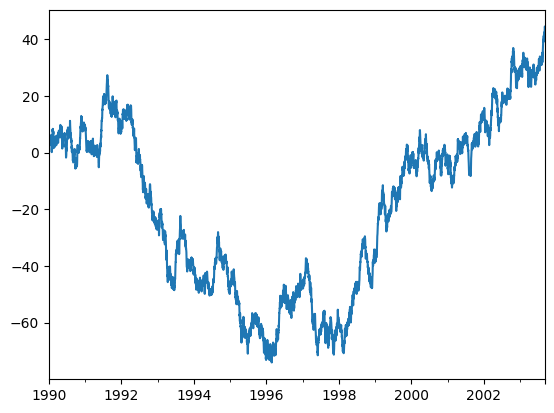

In [113]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [114]:
plt.show();

<Figure size 640x480 with 0 Axes>

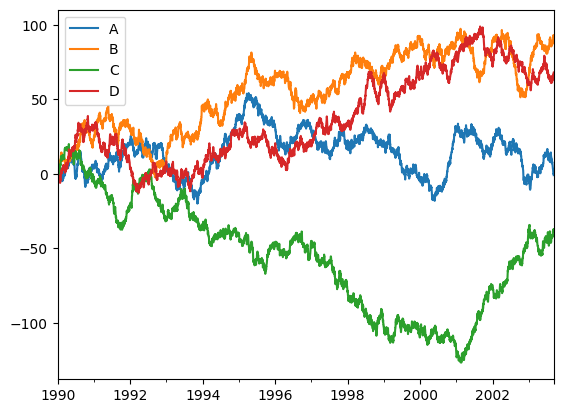

In [115]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [116]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [117]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.170990,0.865625,-0.043609,0.071724
1,1990-01-02,-1.834894,0.417421,0.416729,1.554980
2,1990-01-03,-2.138011,0.258616,-0.485309,2.141074
3,1990-01-04,-2.636270,-1.462440,-1.979445,0.776925
4,1990-01-05,-1.943832,-1.356080,-1.637014,0.072416
...,...,...,...,...,...
4995,2003-09-05,-0.066907,91.905755,-37.898019,66.115922
4996,2003-09-06,-0.273011,93.071998,-37.445385,67.154974
4997,2003-09-07,-0.000600,92.415883,-37.789541,67.465248
4998,2003-09-08,-0.067627,91.894941,-37.403677,67.954461


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [118]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [119]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,-0.170990,0.865625,-0.043609,0.071724
1990-01-02,-1.834894,0.417421,0.416729,1.554980
1990-01-03,-2.138011,0.258616,-0.485309,2.141074
1990-01-04,-2.636270,-1.462440,-1.979445,0.776925
1990-01-05,-1.943832,-1.356080,-1.637014,0.072416
...,...,...,...,...
2003-09-05,-0.066907,91.905755,-37.898019,66.115922
2003-09-06,-0.273011,93.071998,-37.445385,67.154974
2003-09-07,-0.000600,92.415883,-37.789541,67.465248
2003-09-08,-0.067627,91.894941,-37.403677,67.954461


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [120]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [121]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.170990,0.865625,-0.043609,0.071724
1,1990-01-02,-1.834894,0.417421,0.416729,1.554980
2,1990-01-03,-2.138011,0.258616,-0.485309,2.141074
3,1990-01-04,-2.636270,-1.462440,-1.979445,0.776925
4,1990-01-05,-1.943832,-1.356080,-1.637014,0.072416
...,...,...,...,...,...
4995,2003-09-05,-0.066907,91.905755,-37.898019,66.115922
4996,2003-09-06,-0.273011,93.071998,-37.445385,67.154974
4997,2003-09-07,-0.000600,92.415883,-37.789541,67.465248
4998,2003-09-08,-0.067627,91.894941,-37.403677,67.954461


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [122]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -0.576065
b    0.860545
c    1.417069
d    0.206735
e    1.644952
dtype: float64

In [123]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [124]:
pd.Series(np.random.randn(5))

0    0.233034
1    1.856405
2    0.395601
3    1.139256
4    0.211800
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [125]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [126]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [127]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [128]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [129]:
s[s>s.median()]

c    1.417069
e    1.644952
dtype: float64

In [130]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [133]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [134]:
bb[bb.columns[:9]].dtypes

Unnamed: 0                         object
Unnamed: 1                         object
Unnamed: 2                         object
Unnamed: 3                         object
Unnamed: 4                         object
Unnamed: 5                         object
Unnamed: 6                         object
Percent change\nJan 2023 from -    object
Unnamed: 8                         object
dtype: object

In [135]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

##PyTorch Forecasting
**Building a simple first model**

Starting witha simple fully connected model, it'll take a timeseries of size `input_size` as input and outputs a new timeseries of size `output_size`. 

In [136]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

The above model is not yet a PyTorch Forecasting model but it is easy to get there. As this is a simple model, we will use the `BaseModel`. This base class is modified `LightningModule` with pre-defined hooks for training and validating time series models. The main requirement is for the model to have a forward method.

In [137]:
def forward(self, x:
    # x is a batch generated based on TimeSeriesDataset, here we use the
    # continuous variables for encoder
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.linear(network_input)  #
    
    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])
    
    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

In [139]:
from typing import Dict

from pytorch_forecasting.models import BaseModel

class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

##Passing data to a model

Instead of having to write our own dataloader, we can leverage PyTorch Forecasting’s `TimeSeriesDataSet` to feed data to our model. In fact, PyTorch Forecasting expects us to use a `TimeSeriesDataSet`.

The data has to be in a specific format to be used by the `TimeSeriesDataSet`. It should be in a pandas DataFrame and have a categorical column to identify each series and a integer column to specify the time of the record.

Below, we create such a dataset with 30 different observations - 10 for 3 time series.

In [140]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) -0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data 

,value,group,time_idx
0,-0.136630,0,0
1,0.147230,0,1
2,-0.290954,0,2
3,-0.040380,0,3
4,0.144690,0,4
5,0.148015,0,5
6,-0.465615,0,6
7,-0.034022,0,7
8,-0.418800,0,8
9,0.022567,0,9


We can convert it to a `TimeSeriesDataSet` easily.

In [141]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

We can take a look at all the defaults and settings preset by PyTorch Forecasting. These are all available as arguments in `TimeSeriesDataSet`.

In [142]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=[],
 	center=True,
 	scale_by_group=False,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True),
  'group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

Now when we take a look at the output of the dataloader. It's `x` will be fed to the model's forward method.

In [143]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 1.7321],
         [-1.3614],
         [ 0.9599],
         [-0.2163],
         [ 1.4926]],

        [[ 0.5826],
         [-1.0581],
         [-0.1199],
         [ 0.5731],
         [ 0.5856]],

        [[-0.5276],
         [ 1.5028],
         [ 0.1176],
         [ 1.2863],
         [-0.5161]],

        [[-1.4442],
         [-0.5276],
         [ 1.5028],
         [ 0.1176],
         [ 1.2863]]]), 'encoder_target': tensor([[ 0.4542, -0.3719,  0.2480, -0.0661,  0.3902],
        [ 0.1472, -0.2910, -0.0404,  0.1447,  0.1480],
        [-0.1493,  0.3930,  0.0230,  0.3352, -0.1462],
        [-0.3941, -0.1493,  0.3930,  0.0230,  0.3352]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[-1.1036],
         [-1.3423]],

        [[-1.7121],
         [-0.0961]],

        [[ 0.3937],
         [ 0.8930]],

        [[-0.5161],
   